In [1]:
import os
os.chdir('..')
os.chdir('..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [2]:
import pandas as pd
import numpy as np
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from src.models import run_pathology_classification
from src.visualization.eeg_plots import plot_eeg_feature_overview

LOG_FILE_PATH = 'results/logs/03_paradox_analysis/exp02_pathology_clf.log'
RESULTS_PATH = 'results/tables/03_paradox_analysis/exp02_pathology_clf/exp02_pathology_clf_results.csv'

PIPELINE_SAVE_DIR = 'models/03_paradox_analysis/exp02_pathology_clf_pipelines'
SHAP_DATA_SAVE_DIR = 'results/shap_data/03_paradox_analysis/exp02_pathology_clf'


METHODS = ['raw', 'sitewise', 'combat', 'neurocombat', 'covbat']

In [ ]:
logger = logging.getLogger('src.models.run_pathology_classification')
logger.setLevel(logging.INFO)

if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

file_handler = logging.FileHandler(LOG_FILE_PATH, mode='w')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
for method in METHODS:
    run_pathology_classification.run_experiment(harmonization_method=method)

# Analysis

In [3]:
results_df = pd.read_csv(RESULTS_PATH)

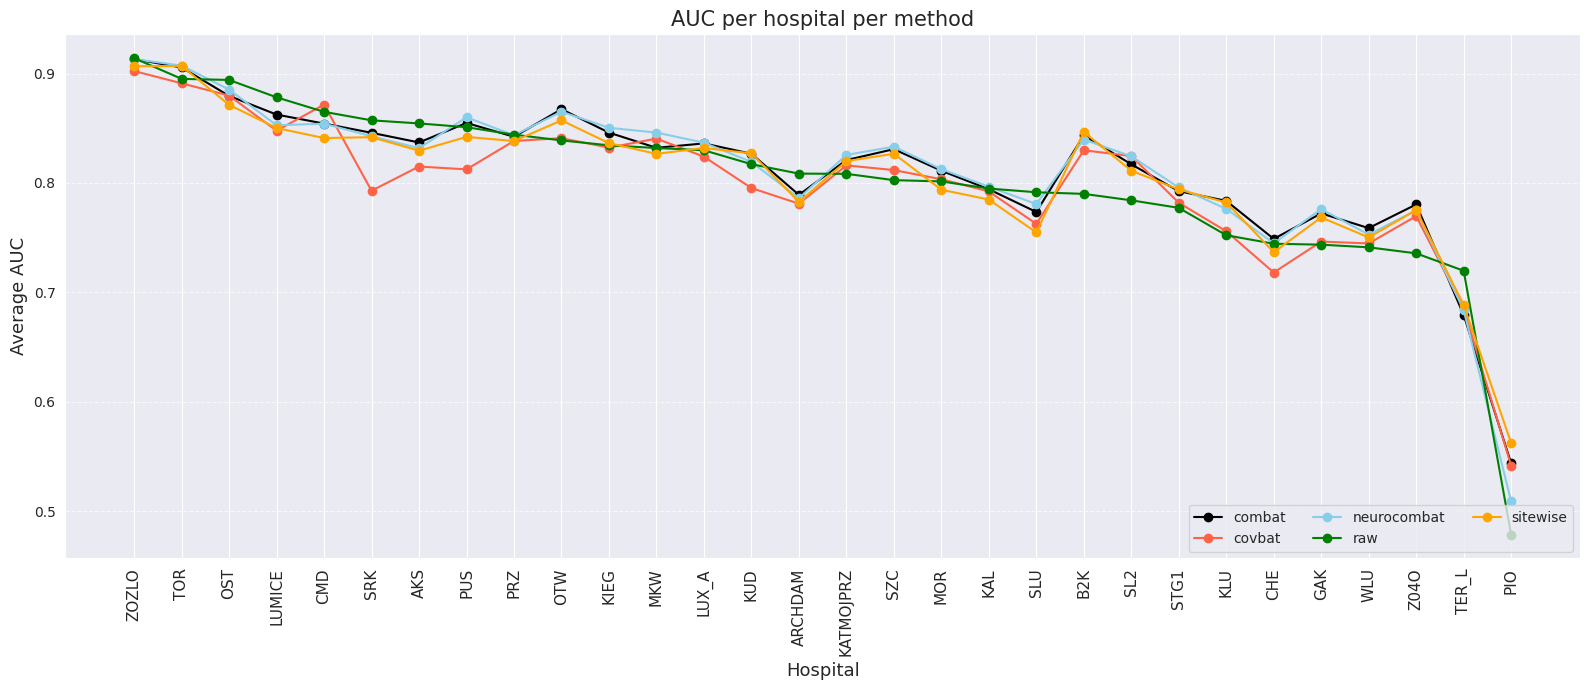

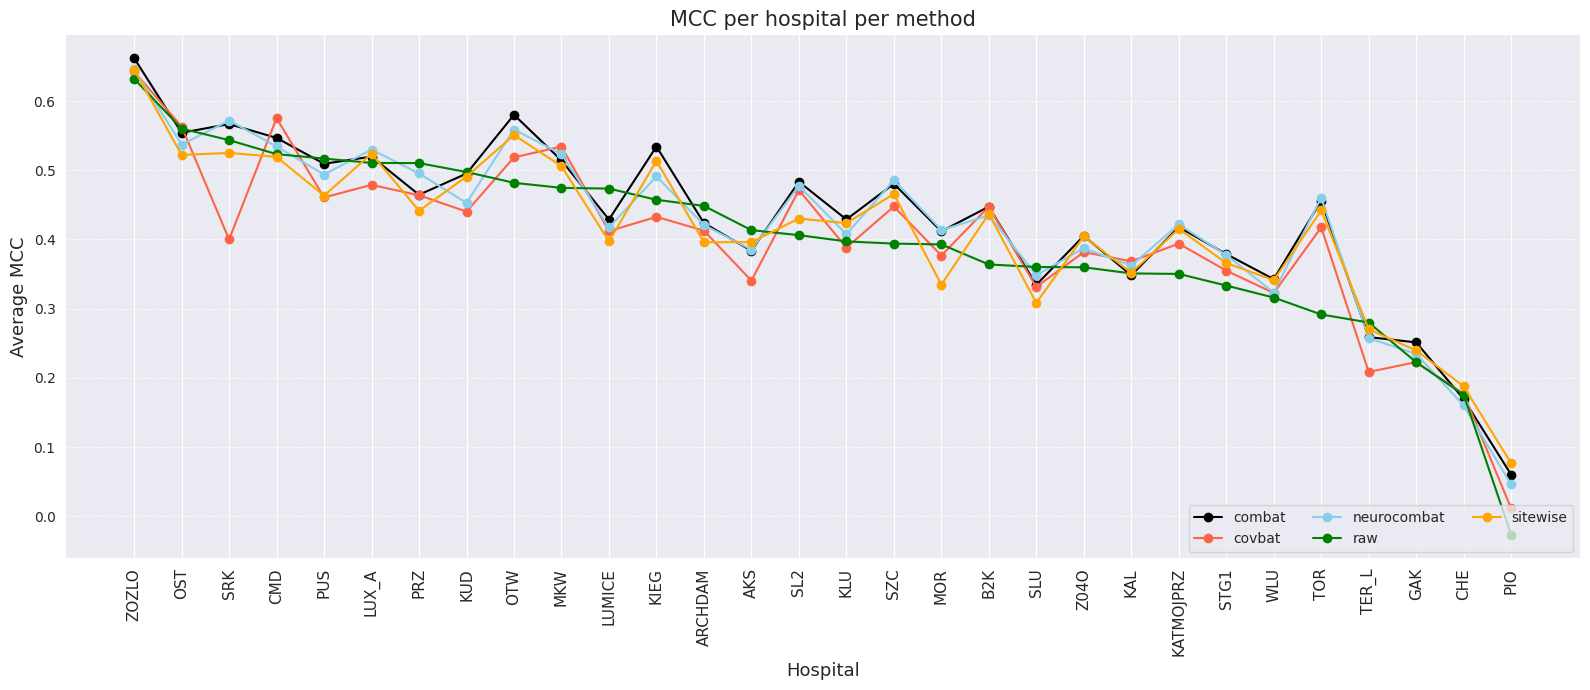

In [4]:
color_grid = [
    'black', 'tomato', 'skyblue', 'green',
    'orange', 'purple', 'brown', 'cyan',
    'magenta', 'yellow', 'pink', 'lime'
]

metrics_to_plot = ['auc', 'mcc']

for metric in metrics_to_plot:
    plt.figure(figsize=(16, 7))

    mean_results_df = results_df.pivot_table(
        index='method',
        columns='hospital',
        values=metric,
        aggfunc='mean'
    )

    reference_series = mean_results_df.loc['raw']
    sort_idx = reference_series.values.argsort()[::-1]
    hospitals_sorted = reference_series.index.values[sort_idx]

    for method_idx, method in enumerate(mean_results_df.index):
        results_series = mean_results_df.loc[method]
        values = [results_series.get(h, np.nan) for h in hospitals_sorted]

        plt.plot(
            hospitals_sorted,
            values,
            marker='o',
            linestyle='-',
            color=color_grid[method_idx % len(color_grid)],
            label=method
        )

    plt.ylabel(f"Average {metric.upper()}", fontsize=13)
    plt.xlabel("Hospital", fontsize=13)
    plt.xticks(rotation=90, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    #plt.ylim(0.5, 1.1)
    plt.legend(loc='lower right', fontsize=10, ncol=3)
    plt.title(f"{metric.upper()} per hospital per method", fontsize=15)
    plt.tight_layout()
    plt.show()

### SHAP analysis

In [5]:
pipelines = {}
test_data = {}
logging.info("Loading all pipelines and test data...")
for method in METHODS:
    pipelines[method] = {}
    test_data[method] = {}
    for hospital in hospitals_sorted:
        pipeline_path = os.path.join(PIPELINE_SAVE_DIR, f'{method}_{hospital}_pipeline.joblib')
        pipelines[method][hospital] = joblib.load(pipeline_path)

        data_path = os.path.join(SHAP_DATA_SAVE_DIR, f'{method}_{hospital}_test_data.parquet')
        test_data[method][hospital] = pd.read_parquet(data_path)

In [10]:
transformed_X = {}
feature_names = {}
for method in METHODS:
    transformed_X[method] = {}
    feature_names[method] = {}
    for hospital in hospitals_sorted:
        pipeline = pipelines[method][hospital]
        data_df = test_data[method][hospital]

        y_test = data_df['y_true']
        X_test = data_df.drop(columns=['y_true'])

        model = pipeline.named_steps['clf']
        feature_names[method][hospital] = model.feature_names_

        if method == 'raw':
            X_transformed = X_test
        else:
            X_transformed = pipeline.named_steps['harmonize'].transform(X_test)

        transformed_X[method][hospital] = pd.DataFrame(X_transformed, columns=feature_names[method][hospital])

/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/dmj/fizmed/kchorzela/licencjat/eeg-site-effects/.venv/lib/python3.11/site-packages/sklearn/utils/validation

In [16]:
shap_values = {}
explainers = {}
for method in METHODS:
    shap_values[method] = {}
    explainers[method] = {}
    for hospital in hospitals_sorted:
        model = pipelines[method][hospital].named_steps['clf']
        X = transformed_X[method][hospital]

        explainers[method][hospital] = None
        shap_values[method][hospital] = model.compute_shap_values(X)

In [21]:
for method in METHODS:
    mean_abs_shap = np.mean(
        [np.abs(shap_values[method][h].values).mean(axis=0) for h in shap_values[method].keys()],
        axis=0
    )
    shap_series = pd.Series(mean_abs_shap, index=transformed_X[method]['AKS'].columns) # Any hospital...
    print(method)
    fig, axs = plot_eeg_feature_overview(
        features_series=shap_series,
        figure_title=f"Method: {method}"
    )
    save_path = f"results/figures/03_paradox_analysis/exp02_pathology_clf/exp02_{method}_shap_overview.png"
    fig.savefig(save_path, dpi=150, bbox_inches='tight')
    logging.info(f"Saved plot to {save_path}")

    plt.close(fig)

raw
sitewise
combat
neurocombat
covbat


In [27]:
for method in METHODS:
    for hospital_id, shap_array in shap_values[method].items():
        mean_abs_shap = np.abs(shap_array.values).mean(axis=0)
        shap_series = pd.Series(mean_abs_shap, index=transformed_X[method][hospital_id].columns)
        print(method)
        fig, axs = plot_eeg_feature_overview(
            features_series=shap_series,
            figure_title=f"Method: {method}, Hospital ID: {hospital_id}"
        )

        save_path_dir = f"results/figures/03_paradox_analysis/exp02_pathology_clf/{method}"
        os.makedirs(save_path_dir, exist_ok=True)
        save_path = save_path_dir + f"/exp02_{method}_{hospital_id}_shap_overview.png"
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        logging.info(f"Saved plot to {save_path}")

        plt.close(fig)

raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
sitewise
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
combat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
neurocombat
covbat
covbat
covbat
covbat
covbat
covba